<a href="https://colab.research.google.com/github/shima2920/Kaggle/blob/main/New_York_City_Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
! pip install -q kaggle

from google.colab import files
files.upload()
#Kaggle account で発行した API token key ファイルを Upload する。

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              215KB  2021-03-07 10:21:15             98  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            106  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            224  
nickuzmenkov/ranzcr-clip-kfold-tfrecords                    RANZCR CLiP KFold TFRecords                         2GB  2021-02-21 13:2

In [131]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction

GCP-Coupons-Instructions.rtf: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


# This is Kaggle Competition "New York City Taxi Fare Prediction"

https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data


# **Summary** 

**02/26/2021**

 

**drop longtitude, latitude and create the distance.And, remove the outlier over 99.5% data.**

The rmse of prediction is: 4.244904591114432

**Remove the outlier over 95.0% data**.

The rmse of prediction is: 3.0105892906116125

But, 5.35489 Public score on LeaderBoard.

**Remove the outlier on passenger_count column**

The rmse of prediction is: 4.216629707647034

4.09802 on LeaderBoard.

**Deep learning**

4.51722 on LeaderBoard.


**Next Step**
Need to fo feature engineering more.
ref:
https://www.kaggle.com/nicapotato/taxi-rides-time-analysis-and-oof-lgbm




# Import library

In [132]:
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

# Import data

Train data set is huge, so import just a part of train data.

In [133]:
train = pd.read_csv('train.csv.zip', nrows = 900000)

In [134]:
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

**Data description**

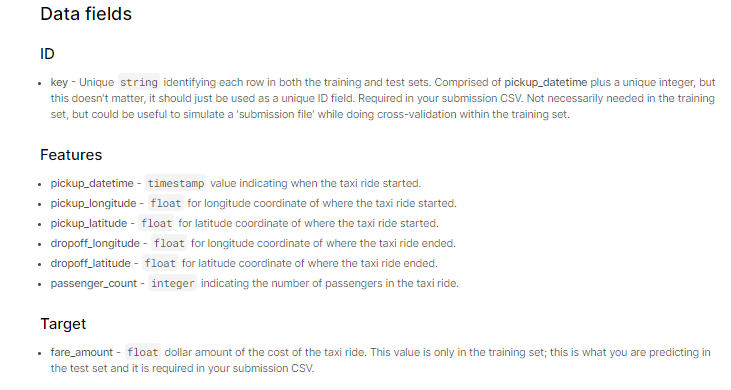

In [135]:
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [136]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [137]:
sample_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [138]:
'''
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train = reduce_mem_usage(train)
test =  reduce_mem_usage(test)
'''

"\n## Function to reduce the DF size\ndef reduce_mem_usage(df, verbose=True):\n    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']\n    start_mem = df.memory_usage().sum() / 1024**2    \n    for col in df.columns:\n        col_type = df[col].dtypes\n        if col_type in numerics:\n            c_min = df[col].min()\n            c_max = df[col].max()\n            if str(col_type)[:3] == 'int':\n                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:\n                    df[col] = df[col].astype(np.int8)\n                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:\n                    df[col] = df[col].astype(np.int16)\n                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:\n                    df[col] = df[col].astype(np.int32)\n                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:\n                    df[col] = df[col].astype(np.int64)  \n 

In [139]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (900000, 8)
Testing Features shape:  (9914, 7)


# Check missing value

In [140]:
#train
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(434)

,Total,Percent
dropoff_latitude,10,0.001111
dropoff_longitude,10,0.001111
passenger_count,0,0.000000
pickup_latitude,0,0.000000
pickup_longitude,0,0.000000
pickup_datetime,0,0.000000
fare_amount,0,0.000000
key,0,0.000000


There are 10 missing values, need to remove these rows.

In [141]:
train = train.dropna(how='any')

In [142]:
train.shape

(899990, 8)

In [143]:
#Test
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(100)

,Total,Percent
passenger_count,0,0.0
dropoff_latitude,0,0.0
dropoff_longitude,0,0.0
pickup_latitude,0,0.0
pickup_longitude,0,0.0
pickup_datetime,0,0.0
key,0,0.0


There are no missing value in both of train and test data.

# Check data summary

In [144]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

resumetable(train)[:25]

Dataset Shape: (899990, 8)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,key,object,0,899990,2009-06-15 17:26:21.0000001,2010-01-05 16:52:16.0000002,2011-08-18 00:35:00.00000049,19.78
1,fare_amount,float64,0,2060,4.5,16.9,5.7,6.45
2,pickup_datetime,object,0,785493,2009-06-15 17:26:21 UTC,2010-01-05 16:52:16 UTC,2011-08-18 00:35:00 UTC,19.50
3,pickup_longitude,float64,0,110613,-73.8443,-74.016,-73.9827,15.90
4,pickup_latitude,float64,0,141141,40.7213,40.7113,40.7613,16.26
5,dropoff_longitude,float64,0,130161,-73.8416,-73.9793,-73.9912,16.07
6,dropoff_latitude,float64,0,165680,40.7123,40.782,40.7506,16.44
7,passenger_count,int64,0,7,1,1,2,1.51


In [145]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,899990.000000,899990.000000,899990.000000,899990.000000,899990.000000,899990.000000
mean,11.346465,-72.530258,39.931220,-72.530185,39.921118,1.684834
std,9.820080,12.175210,7.756175,11.370009,8.393865,1.307946
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992058,40.734962,-73.991390,40.734036,1.000000
50%,8.500000,-73.981797,40.752688,-73.980148,40.753162,1.000000
75%,12.500000,-73.967102,40.767133,-73.963670,40.768123,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,6.000000


There are minus value in fare_amount, so need to remove minus values.

In [146]:
train = train[train['fare_amount'] > 0 ]
train.reset_index(drop=True).head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [147]:
train.shape

(899929, 8)

Also, there are some incorrect value on passenger_count like 0, 200.

So, need to remove these outlier over 7 and under 1.

In [148]:
train = train[train['passenger_count'] > 0 ]
train = train[train['passenger_count'] < 7 ]
train.reset_index(drop=True).head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [149]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,896719.000000,896719.000000,896719.000000,896719.000000,896719.000000,896719.000000
mean,11.356641,-72.529599,39.930770,-72.529861,39.920813,1.690879
std,9.829286,12.183613,7.763742,11.374937,8.402670,1.306398
min,0.010000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,1.000000
25%,6.000000,-73.992058,40.734959,-73.991387,40.734035,1.000000
50%,8.500000,-73.981796,40.752685,-73.980146,40.753162,1.000000
75%,12.500000,-73.967100,40.767132,-73.963666,40.768123,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,6.000000


In [150]:
train.shape

(896719, 8)

In [151]:
resumetable(test)[:25]

Dataset Shape: (9914, 7)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,key,object,0,9914,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24.0000003,2011-10-08 11:53:44.0000002,13.28
1,pickup_datetime,object,0,1753,2015-01-27 13:08:24 UTC,2015-01-27 13:08:24 UTC,2011-10-08 11:53:44 UTC,8.87
2,pickup_longitude,float64,0,9125,-73.9733,-73.9869,-73.9825,13.11
3,pickup_latitude,float64,0,9247,40.7638,40.7194,40.7513,13.14
4,dropoff_longitude,float64,0,9142,-73.9814,-73.9989,-73.9797,13.11
5,dropoff_latitude,float64,0,9360,40.7438,40.7392,40.7461,13.16
6,passenger_count,int64,0,6,1,1,1,1.46


In [152]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


# EDA

Let's see the fare distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


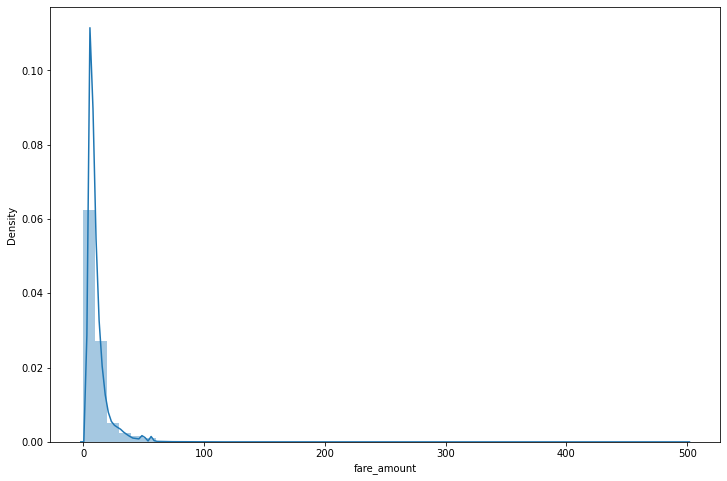

<Figure size 432x288 with 0 Axes>

In [153]:
plt.figure(figsize=(12,8))
sns.distplot( train['fare_amount'],  bins=50, kde=True);
fig = plt.figure()

Therea re some outlier, so need to remove these value.

In [154]:
###上位〇〇%, 下位△△%をulimit/llimitの値に置き換える(外れ値の除去)####################################
for col in ["fare_amount"]:
    ulimit = np.percentile(train[col].values, 99.5)
    llimit = np.percentile(train[col].values, 0.5)
    train[col].iloc[train[col]>ulimit] = ulimit
    train[col].iloc[train[col]<llimit] = llimit

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [155]:
train.shape

(896719, 8)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


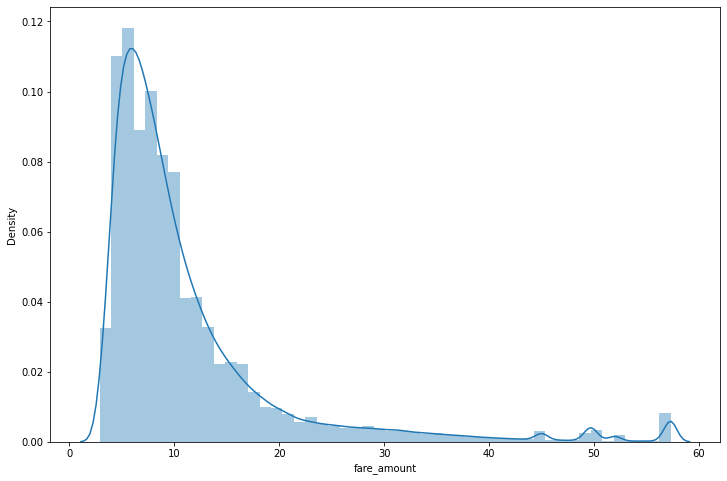

<Figure size 432x288 with 0 Axes>

In [156]:
plt.figure(figsize=(12,8))
sns.distplot( train['fare_amount'],  bins=50, kde=True);
fig = plt.figure()

Lets see the time series data.

# Preprocessing for key and datetime.

Firstly, it seems key value fields are not needed, bacause these value is just ID and timestamp that is included in other variables.

In [157]:
train = train.drop(['key'], axis = 1)
test = test.drop(['key'], axis = 1)

In [158]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Split the pickup_datetime into Year, Month, Hour. Day, minute, seconds seems no relation with target value, so we can ignore.

Year, Month : Fare would be changed based on the season.

weekday : Its also can be changed

hour : midnight fare would be exist.

In [159]:
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])
train["Year"] = train["pickup_datetime"].apply(lambda x:x.year)
train["Month"] = train["pickup_datetime"].apply(lambda x:x.month)
train['weekday'] = train["pickup_datetime"].apply(lambda t: t.weekday())
train["hour"] = train["pickup_datetime"].apply(lambda x:x.hour)
train = train.drop(['pickup_datetime'], axis = 1)

In [160]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,weekday,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,7


In [161]:
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"])
test["Year"] = test["pickup_datetime"].apply(lambda x:x.year)
test["Month"] = test["pickup_datetime"].apply(lambda x:x.month)
test['weekday'] = test["pickup_datetime"].apply(lambda t: t.weekday())
test["hour"] = test["pickup_datetime"].apply(lambda x:x.hour)
test = test.drop(['pickup_datetime'], axis = 1)

In [162]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,weekday,hour
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21


In [163]:
def time_slicer(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,12])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i],color=color)
        ax[i].set_ylabel(value.replace("_", " ").title())
        ax[i].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i].set_xlabel("")
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)

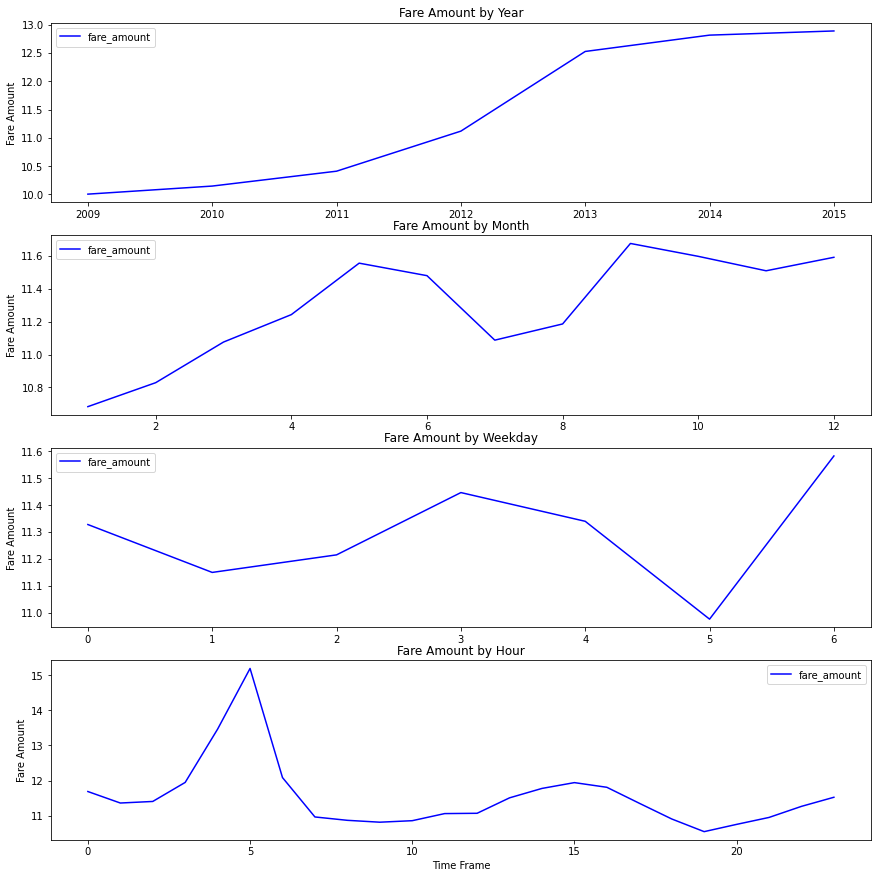

In [164]:
time_slicer(df=train, timeframes=['Year',"Month", "weekday", "hour"], value = "fare_amount", color="blue")

# EDA

Lets see the relationship between target value and other variables.

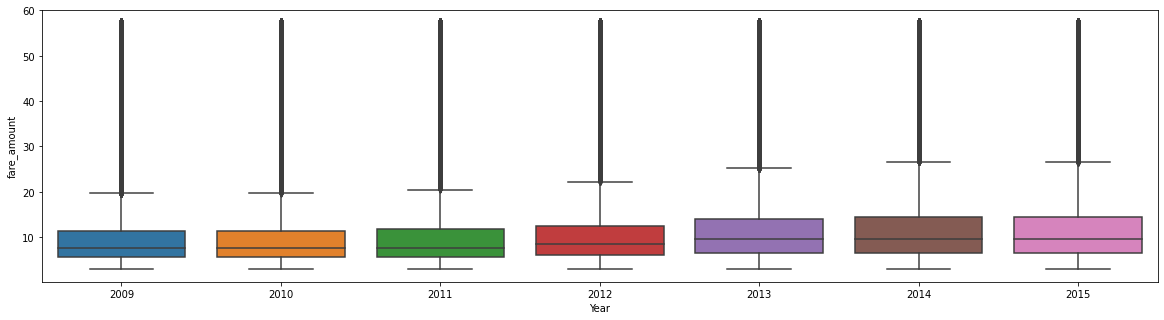

In [165]:
import seaborn as sn
fig1,ax1 = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="Year",y="fare_amount",orient="v",ax=ax1)

Fare are getting a bit increased year to year.

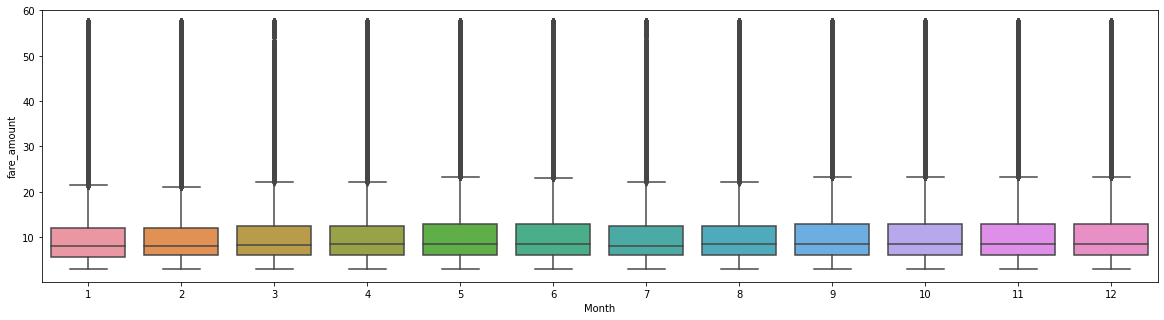

In [166]:
fig1,ax1 = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="Month",y="fare_amount",orient="v",ax=ax1)

Fare is the same through year.

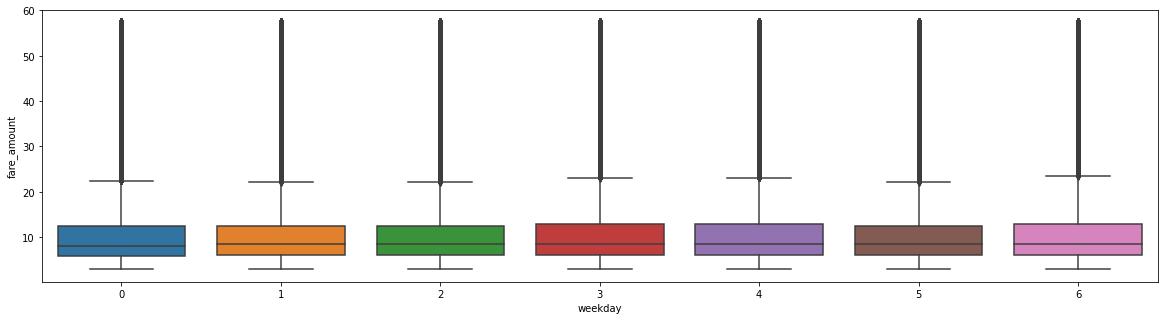

In [167]:
fig1,ax1 = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="weekday",y="fare_amount",orient="v",ax=ax1)

Fare is the same through week.

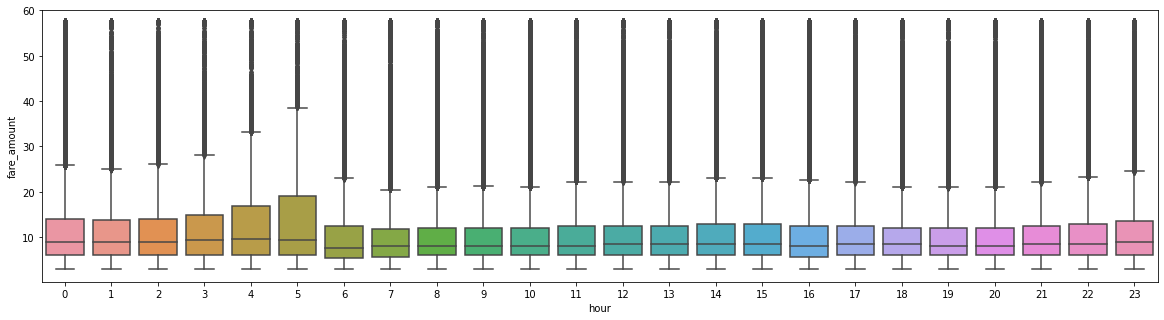

In [168]:
fig1,ax1 = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="hour",y="fare_amount",orient="v",ax=ax1)

Fare is higher in midnight.

In [169]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,weekday,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,7


# Preprocessing for longtitude, latitude.

We can create distance variable from pickup/dropoff longtitude and latitiude.

First, lets drop the outlier on latitude, longtitude.

In [170]:
train.shape

(896719, 10)

In [171]:
train = train.drop((train[train['pickup_latitude']<-90]).index, axis=0)
train = train.drop((train[train['pickup_latitude']>90]).index, axis=0)
train = train.drop((train[train['pickup_longitude']<-180]).index, axis=0)
train = train.drop((train[train['pickup_longitude']>180]).index, axis=0)

In [172]:
test = test.drop((test[test['pickup_latitude']<-90]).index, axis=0)
test = test.drop((test[test['pickup_latitude']>90]).index, axis=0)
test = test.drop((test[test['pickup_longitude']<-180]).index, axis=0)
test = test.drop((test[test['pickup_longitude']>180]).index, axis=0)

In [173]:
train.shape

(896699, 10)

In [174]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

In [175]:
# add new column to dataframe with distance in miles
train['distance_miles'] = distance(train.pickup_latitude, train.pickup_longitude, train.dropoff_latitude, train.dropoff_longitude)

In [176]:
train['distance_miles']

0         0.640487
1         5.250670
2         0.863411
3         1.739386
4         1.242218
            ...   
899995    1.585714
899996    1.119175
899997    1.366745
899998    0.314465
899999    2.447914
Name: distance_miles, Length: 896699, dtype: float64

In [177]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,weekday,hour,distance_miles
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,0,17,0.640487
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,1,16,5.250670
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,3,0,0.863411
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,5,4,1.739386
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,1,7,1.242218


In [178]:
# add new column to dataframe with distance in miles
test['distance_miles'] = distance(test.pickup_latitude, test.pickup_longitude, test.dropoff_latitude, test.dropoff_longitude)

Calculating pickup and drop distance from all 3 airports of Air Ports

In [179]:
def transform(data):
    # Distances to nearby airports, 
    jfk = (-73.7781, 40.6413)
    ewr = (-74.1745, 40.6895)
    lgr = (-73.8740, 40.7769)

    data['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0],
                                         data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], 
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    
    return data

train = transform(train)
test = transform(test)

In [180]:
test.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Year,Month,weekday,hour,distance_miles,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,13,1.443607,13.274326,12.792807,11.718491,10.785343,5.275249,6.068721
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,13,1.507044,12.196699,13.399582,10.042731,9.817205,7.119935,7.035995
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,5,11,0.384398,13.130080,12.804646,10.921174,10.928398,5.949126,5.923673
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,5,21,1.218529,13.766807,13.485374,11.478334,10.550950,5.642243,6.338990
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,5,21,3.347514,14.216819,13.127774,12.926314,10.450604,4.896995,6.401733


It seems the latitude and longtitude columns are no more needed, because, we could calculate the distance based on these values.

So, dorp these columns.

In [181]:
train=train.drop(['pickup_longitude'],axis=1)
train=train.drop(['pickup_latitude'],axis=1)
train=train.drop(['dropoff_longitude'],axis=1)
train=train.drop(['dropoff_latitude'],axis=1)

In [182]:
test=test.drop(['pickup_longitude'],axis=1)
test=test.drop(['pickup_latitude'],axis=1)
test=test.drop(['dropoff_longitude'],axis=1)
test=test.drop(['dropoff_latitude'],axis=1)

In [183]:
train = train.drop((train[train['distance_miles']<0.5]).index, axis=0)
#test = test.drop((test[test['distance_miles']<0.5]).index, axis=0)

In [184]:
train = train.drop((train[train['distance_miles']>200]).index, axis=0)
#test = test.drop((test[test['distance_miles']>200]).index, axis=0)

In [185]:
train.head()

,fare_amount,passenger_count,Year,Month,weekday,hour,distance_miles,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr
0,4.5,1,2009,6,0,17,0.640487,6.527098,5.926672,17.433727,17.508086,4.142790,4.776039
1,16.9,1,2010,1,1,16,5.250670,13.373879,14.335733,8.435586,12.054959,8.708241,5.518847
2,5.7,2,2011,8,3,0,0.863411,13.550258,13.478114,11.198778,10.482997,5.791580,6.399678
3,7.7,1,2012,4,5,4,1.739386,12.657169,13.789559,10.266000,10.687245,6.648280,6.287901
4,5.3,1,2010,3,1,7,1.242218,13.254398,13.577000,12.092157,13.133498,4.961705,4.350323


In [186]:
train.describe()

,fare_amount,passenger_count,Year,Month,weekday,hour,distance_miles,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr
count,786037.000000,786037.000000,786037.000000,786037.000000,786037.00000,786037.000000,786037.000000,786037.000000,786037.000000,786037.000000,786037.000000,786037.000000,786037.000000
mean,11.878544,1.691667,2011.750265,6.276844,3.04548,13.527952,2.293725,17.190982,17.222075,15.638634,15.731248,10.254498,10.264185
std,9.214437,1.305145,1.863628,3.431422,1.95259,6.550055,2.659748,197.282078,197.281098,197.550257,197.549720,197.651900,197.653294
min,2.900000,1.000000,2009.000000,1.000000,0.00000,0.000000,0.500002,0.133527,0.115066,0.314337,0.171389,0.027969,0.087890
25%,6.500000,1.000000,2010.000000,3.000000,1.00000,9.000000,0.935711,12.776077,12.750162,10.158248,10.243719,5.218579,5.175923
50%,8.900000,1.000000,2012.000000,6.000000,3.00000,14.000000,1.495800,13.168042,13.164650,11.065470,11.168630,5.986677,5.926325
75%,13.300000,2.000000,2013.000000,9.000000,5.00000,19.000000,2.640041,13.602966,13.620579,12.083671,12.314468,6.864363,6.842009
max,57.330000,6.000000,2015.000000,12.000000,6.00000,23.000000,186.232920,9362.903151,9363.468886,9373.465852,9374.062796,9373.451145,9374.019134


# Copare multiple refression model

In [187]:
'''
from sklearn.model_selection import train_test_split

x_train=train.drop('fare_amount',axis=1)
y_train=train['fare_amount']
'''


"\nfrom sklearn.model_selection import train_test_split\n\nx_train=train.drop('fare_amount',axis=1)\ny_train=train['fare_amount']\n"

In [188]:
'''
X_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train,test_size=0.20,random_state=12345)

print("X_train: "+str(X_train.shape))
print("X_test: "+str(X_test.shape))
print("Y_train: "+str(Y_train.shape))
print("Y_test: "+str(Y_test.shape))
'''


'\nX_train, X_test, Y_train, Y_test = train_test_split(x_train,y_train,test_size=0.20,random_state=12345)\n\nprint("X_train: "+str(X_train.shape))\nprint("X_test: "+str(X_test.shape))\nprint("Y_train: "+str(Y_train.shape))\nprint("Y_test: "+str(Y_test.shape))\n'

In [189]:
'''
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
#lgb は個別で実施する必要がある可能性有。
'''


'\nfrom sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve\nfrom sklearn.metrics import mean_absolute_error\nfrom sklearn.linear_model import Lasso\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.linear_model import Ridge\nfrom sklearn.linear_model import ElasticNet\nfrom sklearn.neighbors import KNeighborsRegressor\nfrom sklearn.svm import SVR\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.ensemble import GradientBoostingRegressor\nfrom sklearn.ensemble import AdaBoostRegressor\nfrom sklearn.tree import DecisionTreeRegressor\nfrom xgboost import XGBRegressor\nimport lightgbm as lgb\n#lgb は個別で実施する必要がある可能性有。\n'

In [190]:
'''
#機械学習モデルをリストに格納
random_state = 2
classifiers = []
classifiers.append(Lasso(random_state=random_state))
classifiers.append(LinearRegression())
classifiers.append(Ridge(random_state=random_state))
classifiers.append(ElasticNet(random_state=random_state))
classifiers.append(KNeighborsRegressor())
classifiers.append(SVR())
classifiers.append(RandomForestRegressor(random_state=random_state))
classifiers.append(GradientBoostingRegressor())
classifiers.append(AdaBoostRegressor(random_state = random_state))
classifiers.append(DecisionTreeRegressor())
classifiers.append(XGBRegressor())
classifiers.append(lgb.LGBMRegressor())
'''


'\n#機械学習モデルをリストに格納\nrandom_state = 2\nclassifiers = []\nclassifiers.append(Lasso(random_state=random_state))\nclassifiers.append(LinearRegression())\nclassifiers.append(Ridge(random_state=random_state))\nclassifiers.append(ElasticNet(random_state=random_state))\nclassifiers.append(KNeighborsRegressor())\nclassifiers.append(SVR())\nclassifiers.append(RandomForestRegressor(random_state=random_state))\nclassifiers.append(GradientBoostingRegressor())\nclassifiers.append(AdaBoostRegressor(random_state = random_state))\nclassifiers.append(DecisionTreeRegressor())\nclassifiers.append(XGBRegressor())\nclassifiers.append(lgb.LGBMRegressor())\n'

In [191]:
'''
#複数のclassifier の適用
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring='neg_mean_squared_error', cv =10, n_jobs=4))
#cross_val_score は、各foldでのバリデーションデータへの予測スコアを合わせて評価する
'''


"\n#複数のclassifier の適用\ncv_results = []\nfor classifier in classifiers :\n    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring='neg_mean_squared_error', cv =10, n_jobs=4))\n#cross_val_score は、各foldでのバリデーションデータへの予測スコアを合わせて評価する\n"

In [192]:
'''
#適用したclassifierのスコアを取得    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["Lasso","LinearRegression","Ridge",
"ElasticNet","KNeighborsRegressor","SVR","RandomForestRegressor","GradientBoostingRegressor","AdaBoostRegressor","DecisionTreeRegressor", "XGBRegressor","LGBMRegressor"]})
'''


'\n#適用したclassifierのスコアを取得    \ncv_means = []\ncv_std = []\nfor cv_result in cv_results:\n    cv_means.append(cv_result.mean())\n    cv_std.append(cv_result.std())\n\ncv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["Lasso","LinearRegression","Ridge",\n"ElasticNet","KNeighborsRegressor","SVR","RandomForestRegressor","GradientBoostingRegressor","AdaBoostRegressor","DecisionTreeRegressor", "XGBRegressor","LGBMRegressor"]})\n'

In [193]:
'''
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")
'''


'\ng = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{\'xerr\':cv_std})\ng.set_xlabel("Mean Accuracy")\ng = g.set_title("Cross validation scores")\n'

In [194]:
'''
cv_res.sort_values(ascending=False, by='CrossValMeans')
'''


"\ncv_res.sort_values(ascending=False, by='CrossValMeans')\n"

In [195]:
'''
from sklearn import datasets
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
#import optuna
 
def objective(trial):
    params = {
        'alpha': trial.suggest_loguniform("alpha", 0.1, 5), 
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'normalize': trial.suggest_categorical('normalize', [True, False]),
    }
 
    reg = Ridge(**params)#Cross Validation Scores の低いmodel を採用する
    reg.fit(X_train, Y_train)
    y_pred = reg.predict(X_test)
 
    mae = mean_absolute_error(Y_test, y_pred)
    return mae

'''


'\nfrom sklearn import datasets\nfrom sklearn.linear_model import Ridge\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_absolute_error\n#import optuna\n \ndef objective(trial):\n    params = {\n        \'alpha\': trial.suggest_loguniform("alpha", 0.1, 5), \n        \'fit_intercept\': trial.suggest_categorical(\'fit_intercept\', [True, False]),\n        \'normalize\': trial.suggest_categorical(\'normalize\', [True, False]),\n    }\n \n    reg = Ridge(**params)#Cross Validation Scores の低いmodel を採用する\n    reg.fit(X_train, Y_train)\n    y_pred = reg.predict(X_test)\n \n    mae = mean_absolute_error(Y_test, y_pred)\n    return mae\n\n'

In [196]:
'''
#optuna でハイパーパラメータチューニング
pip install optuna
'''


'\n#optuna でハイパーパラメータチューニング\npip install optuna\n'

In [197]:
'''
import optuna
study = optuna.create_study()
study.optimize(objective, n_trials=100)

# 結果を表示
print(f'best score: {study.best_value:.4f}, best params: {study.best_params}')
'''


"\nimport optuna\nstudy = optuna.create_study()\nstudy.optimize(objective, n_trials=100)\n\n# 結果を表示\nprint(f'best score: {study.best_value:.4f}, best params: {study.best_params}')\n"

In [198]:
'''
params = {'alpha': 1.9510706324753746, 'fit_intercept': True, 'normalize': True}
#alphaを増やす　-> 正則化が強くなる -> モデルは簡潔になる
#alphaを減らす　-> 正則化が弱くなる -> モデルは複雑になる
#正則化とは過剰適合(過学習)を防ぐために、モデルが複雑になりすぎないように制約すること。
reg = ElasticNet(**params)
reg.fit(X_train, Y_train)
prediction_log = reg.predict(test)
prediction =np.exp(prediction_log) 
#print(prediction)
print(prediction_log)
#target value を対数変換した場合は、prediction_log ではなく prediction に変換する必要がある。
'''


"\nparams = {'alpha': 1.9510706324753746, 'fit_intercept': True, 'normalize': True}\n#alphaを増やす\u3000-> 正則化が強くなる -> モデルは簡潔になる\n#alphaを減らす\u3000-> 正則化が弱くなる -> モデルは複雑になる\n#正則化とは過剰適合(過学習)を防ぐために、モデルが複雑になりすぎないように制約すること。\nreg = ElasticNet(**params)\nreg.fit(X_train, Y_train)\nprediction_log = reg.predict(test)\nprediction =np.exp(prediction_log) \n#print(prediction)\nprint(prediction_log)\n#target value を対数変換した場合は、prediction_log ではなく prediction に変換する必要がある。\n"

# Modeling LightGBM with Optuna

In [199]:

x_train = train.drop(['fare_amount'], axis = 1)
y_train = train['fare_amount']


In [200]:

# Train/validation用にデータ分割
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)


In [201]:

#LightGBM用のデータ作成
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_valid = lgb.Dataset(X_test, Y_test, reference=lgb_train)


In [202]:

# to record eval results for plotting
evals_result = {} 


In [203]:

#OptunaチューニングParam
optuna_params = {
    'task': 'train',
    #'boosting_type': 'gbdt',
    'objective': 'regression',# regression(回帰), binary(二値分類, ラベルは0,1),multiclass(多クラス分類, metricとしては、multi_logloss, multi_error(正答率))
    'metric': "mse", #regression : 絶対値誤差関数(L1)ならばmae, 2乗誤差関数(L2)ならばmseと指定, rmse
                      #binary : binary_logloss(クロスエントロピー)とbinary_error(正答率)の2つ
                      #multiclass : multi_logloss(softmax関数)とmulti_error(正答率)の2つ
    #'num_leaves': 20,#木にある分岐の個数．デフォルトは31, 大きくすると精度は上がるが過学習が進む
    #'max_depth': 10,#木構造の深さを限定するための変数．データが少ないときに過学習を防ぐために設定する．デフォルト値は-1で0以下の値は制限なしを意味する．
    #'learning_rate': 0.05,#学習率。デフォルトは0.1
    #'feature_fraction': 0.9,#学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する．
    #'min_data_in_leaf':4,#大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．
    #'verbose':50
}


In [204]:

#Optunaを用いて最適化し、LGBにTrainさせる
model = lgb.train(optuna_params,
                  lgb_train,
                  valid_sets=lgb_valid,
                  verbose_eval=0,
                  num_boost_round=10000,
                  early_stopping_rounds=100
                  )
          


In [205]:

y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)



In [206]:
# eval rmse
print('\nThe rmse of prediction is:', mean_squared_error(Y_test, y_pred_test) ** 0.5)
accuracy = mean_squared_error(Y_test, y_pred_test) ** 0.5




The rmse of prediction is: 2.7673721783623675


In [207]:

best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))


Best params: {'task': 'train', 'objective': 'regression', 'metric': 'mse'}
  Accuracy = 2.7673721783623675
  Params: 
    task: train
    objective: regression
    metric: mse


In [208]:
y_pred = model.predict(test, num_iteration=model.best_iteration)

# Deep Learning

In [209]:
'''
train_df, test_df = train_test_split(train, test_size=0.10, random_state=1)
'''


'\ntrain_df, test_df = train_test_split(train, test_size=0.10, random_state=1)\n'

In [210]:
'''
# Get labels
train_labels = train_df['fare_amount'].values
test_labels = test_df['fare_amount'].values
train_df = train_df.drop(['fare_amount'], axis=1)
test_df = test_df.drop(['fare_amount'], axis=1)
'''


"\n# Get labels\ntrain_labels = train_df['fare_amount'].values\ntest_labels = test_df['fare_amount'].values\ntrain_df = train_df.drop(['fare_amount'], axis=1)\ntest_df = test_df.drop(['fare_amount'], axis=1)\n"

In [211]:
'''
# Scale data
# Note: im doing this here with sklearn scaler but, on the Coursera code the scaling is done with Dataflow and Tensorflow
scaler = preprocessing.MinMaxScaler()#0-1に正規化
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)
test_scaled = scaler.transform(test)
'''


'\n# Scale data\n# Note: im doing this here with sklearn scaler but, on the Coursera code the scaling is done with Dataflow and Tensorflow\nscaler = preprocessing.MinMaxScaler()#0-1に正規化\ntrain_df_scaled = scaler.fit_transform(train_df)\ntest_df_scaled = scaler.transform(test_df)\ntest_scaled = scaler.transform(test)\n'

In [212]:
'''
from keras import regularizers
from keras.layers import Dense, BatchNormalization, Activation
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))#activationは、特徴の学習をしやすくするために、データを整える。
#ReLuは「0より大きければそのまま、0より小さければ0に置き換えて」出力, 回帰分析
#Sigmoidは「0から1の間にマッピングしなおして」出力, 分類
model.add(BatchNormalization())# DLにおける各重みパラメータを上手くreparametrizationすることで、ネットワークを最適化するための方法の一つ。
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))
'''


"\nfrom keras import regularizers\nfrom keras.layers import Dense, BatchNormalization, Activation\nmodel = Sequential()\nmodel.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1], activity_regularizer=regularizers.l1(0.01)))#activationは、特徴の学習をしやすくするために、データを整える。\n#ReLuは「0より大きければそのまま、0より小さければ0に置き換えて」出力, 回帰分析\n#Sigmoidは「0から1の間にマッピングしなおして」出力, 分類\nmodel.add(BatchNormalization())# DLにおける各重みパラメータを上手くreparametrizationすることで、ネットワークを最適化するための方法の一つ。\nmodel.add(Dense(128, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Dense(64, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Dense(32, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Dense(8, activation='relu'))\nmodel.add(BatchNormalization())\nmodel.add(Dense(1))\n"

In [213]:
'''
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.001
DATASET_SIZE = 6000000
'''


'\nBATCH_SIZE = 256\nEPOCHS = 50\nLEARNING_RATE = 0.001\nDATASET_SIZE = 6000000\n'

In [214]:
'''
from keras import optimizers 
adam = optimizers.Adam(lr=LEARNING_RATE)#adamは、最適化アルゴリズム
model.compile(loss='mse', optimizer=adam, metrics=['mae'])
#mse:平均二乗誤差
#mae:平均絶対誤差
'''


"\nfrom keras import optimizers \nadam = optimizers.Adam(lr=LEARNING_RATE)#adamは、最適化アルゴリズム\nmodel.compile(loss='mse', optimizer=adam, metrics=['mae'])\n#mse:平均二乗誤差\n#mae:平均絶対誤差\n"

In [215]:
'''
print('Dataset size: %s' % DATASET_SIZE)
print('Epochs: %s' % EPOCHS)
print('Learning rate: %s' % LEARNING_RATE)
print('Batch size: %s' % BATCH_SIZE)
print('Input dimension: %s' % train_df_scaled.shape[1])
print('Features used: %s' % train_df.columns)
'''


"\nprint('Dataset size: %s' % DATASET_SIZE)\nprint('Epochs: %s' % EPOCHS)\nprint('Learning rate: %s' % LEARNING_RATE)\nprint('Batch size: %s' % BATCH_SIZE)\nprint('Input dimension: %s' % train_df_scaled.shape[1])\nprint('Features used: %s' % train_df.columns)\n"

In [216]:
'''
model.summary()
'''


'\nmodel.summary()\n'

In [217]:
'''
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)
history = model.fit(x=train_df_scaled, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=1, validation_data=(test_df_scaled, test_labels), 
                    callbacks = [early_stopping],
                    shuffle=True)
#batch_sizeとは 1 回に計算するデータの数
#エポック数とは1と2の手順を何回実行
#1.データセットをバッチサイズに従ってN個のサブセットに分ける。
#2.各サブセットを学習に回す。つまり、N回学習を繰り返す。
'''


"\nfrom keras.callbacks import EarlyStopping\nearly_stopping = EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights = True)\nhistory = model.fit(x=train_df_scaled, y=train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, \n                    verbose=1, validation_data=(test_df_scaled, test_labels), \n                    callbacks = [early_stopping],\n                    shuffle=True)\n#batch_sizeとは 1 回に計算するデータの数\n#エポック数とは1と2の手順を何回実行\n#1.データセットをバッチサイズに従ってN個のサブセットに分ける。\n#2.各サブセットを学習に回す。つまり、N回学習を繰り返す。\n"

In [218]:
'''
def plot_loss_accuracy(history):
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

plot_loss_accuracy(history)
'''


"\ndef plot_loss_accuracy(history):\n    plt.figure(figsize=(20,10))\n    plt.plot(history.history['loss'])\n    plt.plot(history.history['val_loss'])\n    plt.title('model loss')\n    plt.ylabel('loss')\n    plt.xlabel('epoch')\n    plt.legend(['train', 'test'], loc='upper right')\n    plt.show()\n\nplot_loss_accuracy(history)\n"

In [219]:
'''
# Make prediction
y_pred = model.predict(test_scaled, batch_size=128, verbose=1)
'''


'\n# Make prediction\ny_pred = model.predict(test_scaled, batch_size=128, verbose=1)\n'

# Submit

In [220]:
#Submit方法
sub = pd.DataFrame(pd.read_csv('test.csv')['key'])
sub['fare_amount'] = list(map(int, y_pred))
sub.to_csv('submission_yshimamu.csv', index=False)

In [221]:
!kaggle competitions submit new-york-city-taxi-fare-prediction -f submission_yshimamu.csv -m "First commit"

100% 300k/300k [00:01<00:00, 160kB/s]
Successfully submitted to New York City Taxi Fare Prediction